In [13]:
#Code Prototype for 1D Kalman Filter use on EXCLAIM Project with one sensor, code by Joaquin Matticoli

In [14]:
import numpy as np
#from numpy.linalg import inv
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import filterpy.stats as stats
import math
from math import sqrt

In [15]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(predict, update, z1, K):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}     {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z1, update[0], update[1], K))

In [16]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0,inertia=0.0,tau=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)
        self.moment_inertia = I #Dont do anything as of right now
        self.torque2 = tau #Dont do anything as of right now

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std) #is this process variance needed here?
        self.x += dx * dt + (self.torque2 / self.moment_inertia) * 0.5 * dt**2

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas1_std)
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in deg/sec."""
        measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
        return measurement2

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [17]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

I = 3900 # Moment of inertia around azimuth for mission in kg * m^2
number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = 0.1 # variance in the payload's movement
sensor1_var = 0.001 # variance in the sensor
x = gaussian(math.pi/16, 1.)  # payload's initial orientation in rad
angular_velocity = 0.009 # angular velocity in rad/s
spectral_density = 0.2 #Spectral density of the measurement noise
dt = 1. # time step in seconds
total_time = 100. # Total time passed from beginning to end of experiment

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity, process_var) # displacement to add to x
n_iter = math.floor(total_time/dt)
torque = 10 #N*m

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=math.pi/18, 
    angular_velocity2=0.01, 
    measurement1_var=sensor1_var, 
    process_var=process_model.var,
    inertia=I,
    tau=torque)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, ztrue = [], []
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT				UPDATE
     x      var		  z1	    x      var         K
 -0.793    0.110	0.630	  0.618   0.001     0.991
  0.000    0.020	0.749	  0.713   0.001     0.952
  0.000    0.020	1.113	  1.060   0.001     0.952
  0.001    0.020	1.266	  1.206   0.001     0.952
  0.001    0.020	1.790	  1.704   0.001     0.952
  0.001    0.020	2.068	  1.970   0.001     0.952
  0.001    0.020	2.327	  2.217   0.001     0.952
  0.001    0.020	2.514	  2.395   0.001     0.952
  0.001    0.020	2.992	  2.849   0.001     0.952
  0.001    0.020	3.038	  2.894   0.001     0.952
  0.001    0.020	3.474	  3.308   0.001     0.952
  0.002    0.020	3.910	  3.724   0.001     0.952
  0.002    0.020	3.996	  3.806   0.001     0.952
  0.002    0.020	4.021	  3.830   0.001     0.952
  0.002    0.020	4.126	  3.929   0.001     0.952
  0.002    0.020	4.243	  4.041   0.001     0.952
  0.002    0.020	4.813	  4.584   0.001     0.952
  0.002    0.020	5.300	  5.048   0.001     0.952
  0.003    0.020	5.306	  5.054   0.001     0.952
  0.

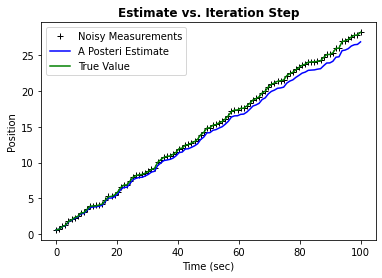

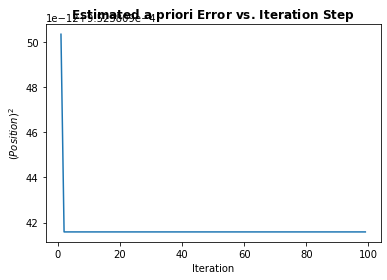

In [18]:
def plotstuff():
    plt.figure()
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Noisy Measurements')
#     plt.plot(np.linspace(0,total_time,len(x1)),x1,'r*',label='A Priori Estimate')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteri Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Position')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

# x1 = np.zeros(n_iter)
Phat = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1:
    print('PREDICT\t\t\t\tUPDATE')
    print('     x      var\t\t  z1\t    x      var         K')

# perform Kalman filter on measurement(s) z
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[0., 1.], 
                [0., 0.]]) #correct for calculating position from position and velocity
f.H = np.array([[1., 0.]]) #this is for first sensor measuring position
f.x = np.array([[x.mean], 
                [angular_velocity+randn()]])
# f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
#                  [(dt**2)/2,  dt      ]]) * spectral_density
f.Q = np.array([[0.01, 0.00001],
                [0.00001, 0.01]])
f.P = np.diag([x.var,process_var]) #Variance
f.R = sensor1_var  #Noise in sensors
f.u = torque
f.B = np.array([[0],
                [1/I]])

for i in range(n_iter):
    f.predict()
    prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
    f.update(zs[i])
    x = gaussian(f.x[0,0], f.P[0,0])
    if printcase == 1:
        print_gh(prior, x, zs[i], f.K[0,0])
    if plotcase == 1:
#         x1[i] = prior.mean
        xhat[i] = x.mean
        Phat[i] = x.var

if printcase == 1:
    print()
    print('final estimate:           {:10.3f}'.format(x.mean))
    print('actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()